In [73]:
import pandas as pd
import geopandas as gpd
# import pycountry
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import plotly.graph_objects as go
from shapely.geometry import Polygon, LineString, Point
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

C:\Users\User\AppData\Local\Temp/ipykernel_13588/1947656152.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centeroid'] = gdf.centroid


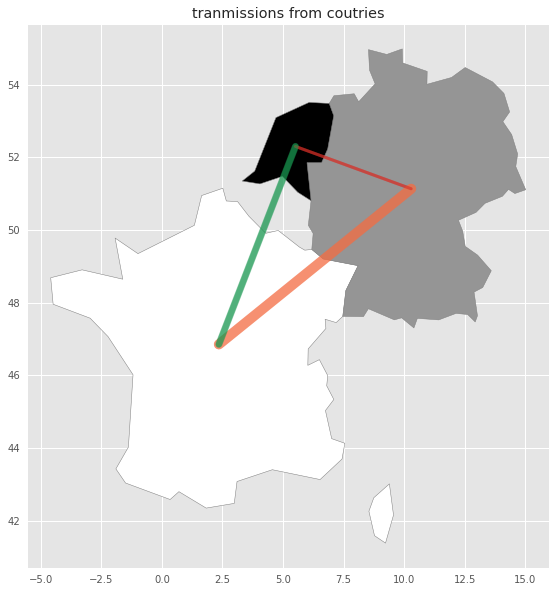

In [74]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries = ["Germany","France","Netherlands"]
value = [1,2,3]
gdf = world.loc[world['name'].isin(countries),:].copy()
gdf['value'] = value
gdf['centeroid'] = gdf.centroid
# gdf = gpd.GeoDataFrame({'value':[1,2,3,4,5,6],'countries': countries})
# gdf['geometry'] = world.loc[world['iso_a3'].isin(countries),'geometry'].to_crs(epsg=3035)
gdf.loc[gdf['name'] == 'France', 'centeroid'] = Point(2.35, 46.85) #gpd.GeoSeries(Point(48.85,2.35))

polygon = Polygon([(-25,35), (40,35), (40,75),(-25,75)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)

ntcs = pd.DataFrame({'from_node' : ["Germany","Germany","France","France","Netherlands","Netherlands"],
                    'to_node' : ["France","Netherlands","Germany","Netherlands","Germany","France",],
                    'ntc' : [10,3,10,7,3,6]})
ntcs['from_coordinates'] = [gdf.loc[gdf['name']== x, 'centeroid'] for x in ntcs['from_node']]
ntcs['to_coordinates'] = [gdf.loc[gdf['name']== x, 'centeroid'] for x in ntcs['to_node']]
ntcs['full_usage'] = [0.2,0.1,0.2,0.9,0.1,0.9]              
# ntcs['line'] = ntcs.apply(lambda x: LineString([x['from_cordinates'], x['to_cordinates']]), axis=1)
# fig,ax=gpd.subplots()
# ax=gdf.plot(ax=ax)
# poly_gdf.plot(edgecolor=”red”,ax=ax, alpha=0.1)
# ntcs['from_coordinates'] = (ntcs['from_coordinates']) + [1,0,1,0,1,0]
gdf = gpd.clip(gdf, polygon)
with plt.style.context(("seaborn", "ggplot")):
    ## Plot countries
    gdf.plot('value', figsize=(18,10), edgecolor="grey")

    ## Loop throughthe NTC data
    # for from_coordinates, to_coordinates, ntc in zip(ntcs['from_coordinates'], ntcs['to_coordinates'], ntcs['ntc']):
    for n in range(len(ntcs)):
        plt.plot([ntcs.loc[n,'from_coordinates'].x , ntcs.loc[n,'to_coordinates'].x] 
                , [ntcs.loc[n,'from_coordinates'].y, ntcs.loc[n,'to_coordinates'].y], 
                linewidth= ntcs.loc[n,'ntc'], color= cm.RdYlGn(ntcs.loc[n,'full_usage']), alpha=0.5 )

    # for slat,dlat, slon, dlon, num_flights in zip(overseas_cnt_df["LatOrig"], overseas_cnt_df["LatDest"], overseas_cnt_df["LongOrig"], overseas_cnt_df["LongDest"], overseas_cnt_df["Num_Of_Flights"]):
    #     plt.plot([slon , dlon], [slat, dlat], linewidth=num_flights/100, color="red", alpha=0.5)

    plt.title("tranmissions from coutries")


    # plt.savefig("connection-map-geopandas-1.png", dpi=100)


In [105]:
# Data import

country_dict = pd.read_csv('data/Map/country_codes.csv').set_index('Code').to_dict()

ntc_df = pd.read_csv('data/Map/Table_2.csv')
ntc_df = ntc_df.loc[~(ntc_df.ntc_max == 0)].reset_index(drop=True)
ntc_df['from_zone'] = [country_dict['Name'][x] for x in ntc_df['from_zone']]
ntc_df['to_zone'] = [country_dict['Name'][x] for x in ntc_df['to_zone']]


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

countries = ntc_df.from_zone.unique()
value = [_ for _ in range(len(countries))]
gdf = world.loc[world['name'].isin(countries),:].copy()
gdf['value'] = value
gdf['centeroid'] = gdf.centroid
# correcting centeroids that seem off
gdf.loc[gdf['name'] == 'France', 'centeroid'] = Point(2.35, 46.85)
gdf.loc[gdf['name'] == 'Norway', 'centeroid'] = Point(7.00, 60.00)
gdf.loc[gdf['name'] == 'Sweden', 'centeroid'] = Point(14.50, 60.00)
gdf.loc[gdf['name'] == 'United Kingdom', 'centeroid'] = Point(-1, 52.00)

ntc_df['from_coordinates'] = [gdf.loc[gdf['name']== x, 'centeroid'] for x in ntc_df['from_zone']]
ntc_df['to_coordinates'] = [gdf.loc[gdf['name']== x, 'centeroid'] for x in ntc_df['to_zone']]

# combining from and to values
coun_pairs = [set([ntc_df.loc[x,'from_zone'],ntc_df.loc[x,'to_zone']]) for x in range(len(ntc_df))]
coun_pairs = list(coun_pairs)
revers = list(reversed(coun_pairs))
lis = []
for x in coun_pairs:
    lis.append([coun_pairs.index(x),revers.index(x)])
lis

new_df = pd.DataFrame(columns=ntc_df.columns)
row = 0
for x in lis:
        new_df.loc[row, 'from_zone'] = ntc_df.loc[x[0],'from_zone']
        new_df.loc[row, 'to_zone'] = ntc_df.loc[x[0],'to_zone']
        new_df.loc[row, 'ntc_max'] = (ntc_df.loc[x[0],'ntc_max'] + ntc_df.loc[x[1],'ntc_max'])/2
        new_df.loc[row, '100%_utlis_oneWay_max'] = max(ntc_df.loc[x[0],'utilisation_equal100'], ntc_df.loc[x[1],'utilisation_equal100'])
        row += 1

new_df = new_df.drop_duplicates().reset_index(drop=True)

new_df['from_coordinates'] = [gdf.loc[gdf['name']== x, 'centeroid'] for x in new_df['from_zone']]
new_df['to_coordinates'] = [gdf.loc[gdf['name']== x, 'centeroid'] for x in new_df['to_zone']]
new_df


C:\Users\User\AppData\Local\Temp/ipykernel_13588/176066446.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centeroid'] = gdf.centroid


,from_zone,to_zone,ntc_max,avg_sum_year,utilisation_percent,utilisation_equal100,utilisation_bigger90,from_coordinates,to_coordinates,100%_utlis_oneWay_max
0,Switzerland,Austria,850.0,NaN,NaN,NaN,NaN,127 POINT (8.11830 46.79174) Name: centeroi...,114 POINT (14.07616 47.61395) Name: centero...,0.673516
1,Czechia,Austria,1220.0,NaN,NaN,NaN,NaN,153 POINT (15.33456 49.77525) Name: centero...,114 POINT (14.07616 47.61395) Name: centero...,0.453767
2,Germany,Austria,2850.0,NaN,NaN,NaN,NaN,121 POINT (10.28849 51.13372) Name: centero...,114 POINT (14.07616 47.61395) Name: centero...,0.835388
3,Italy,Austria,2242.5,NaN,NaN,NaN,NaN,141 POINT (12.14079 42.75118) Name: centero...,114 POINT (14.07616 47.61395) Name: centero...,0.006849
4,Germany,Belgium,850.0,NaN,NaN,NaN,NaN,121 POINT (10.28849 51.13372) Name: centero...,129 POINT (4.58083 50.65244) Name: centeroi...,0.805936
5,France,Belgium,2470.0,NaN,NaN,NaN,NaN,43 POINT (2.35000 46.85000) Name: centeroid...,129 POINT (4.58083 50.65244) Name: centeroi...,0.920776
6,Netherlands,Belgium,1750.0,NaN,NaN,NaN,NaN,130 POINT (5.51222 52.29870) Name: centeroi...,129 POINT (4.58083 50.65244) Name: centeroi...,0.324772
7,United Kingdom,Belgium,3000.0,NaN,NaN,NaN,NaN,143 POINT (-1.00000 52.00000) Name: centero...,129 POINT (4.58083 50.65244) Name: centeroi...,0.400457
8,Germany,Switzerland,3475.0,NaN,NaN,NaN,NaN,121 POINT (10.28849 51.13372) Name: centero...,127 POINT (8.11830 46.79174) Name: centeroi...,0.891210
9,France,Switzerland,1925.0,NaN,NaN,NaN,NaN,43 POINT (2.35000 46.85000) Name: centeroid...,127 POINT (8.11830 46.79174) Name: centeroi...,0.764612


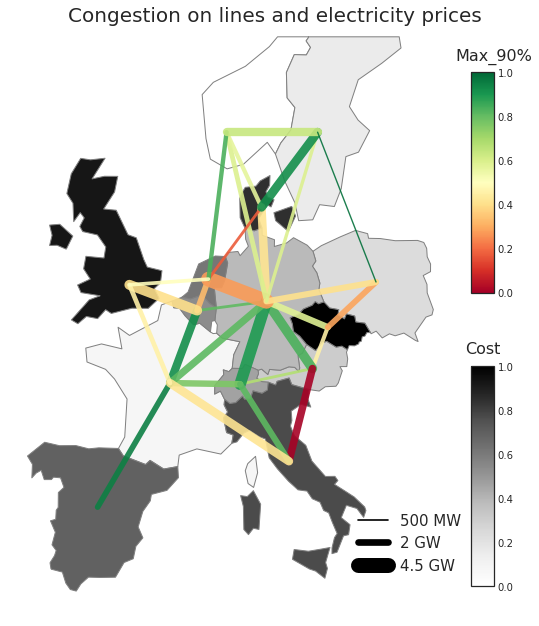

In [213]:
# plotting
polygon = Polygon([(-25,35), (40,35), (40,65),(-25,65)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)
scale_factor = 300
gdf = gpd.clip(gdf, polygon)
with plt.style.context(("seaborn-white")):
    ## Plot countries
    gdf.plot('value', figsize=(8,17), edgecolor="grey")

    ## Loop throughthe NTC data
    # for from_coordinates, to_coordinates, ntc in zip(ntcs['from_coordinates'], ntcs['to_coordinates'], ntcs['ntc']):
    for n in range(len(new_df)):
        plt.plot([new_df.loc[n,'from_coordinates'].x , new_df.loc[n,'to_coordinates'].x] 
                , [new_df.loc[n,'from_coordinates'].y, new_df.loc[n,'to_coordinates'].y], 
                linewidth= new_df.loc[n,'ntc_max']/scale_factor, color= cm.RdYlGn(new_df.loc[n,'100%_utlis_oneWay_max']), alpha=0.9 )
    plt.title("Congestion on lines and electricity prices", fontsize=20, y=0.97, x=0.6)

    plt.box(False)
    plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)

    cax1 = plt.axes([0.93, 0.52, 0.04, 0.18])
    cax2 = plt.axes([0.93, 0.28, 0.04, 0.18])
    
    clb1 = plt.colorbar(cm.ScalarMappable(norm=None, cmap="RdYlGn"), cax=cax1)
    clb1.ax.set_title('Max_90%',fontsize=16, y=1.03, x=1)
    clb2 = plt.colorbar(cm.ScalarMappable(norm=None, cmap=None), cax=cax2)
    clb2.ax.set_title('Cost',fontsize=16, y=1.03)

    line1, = plt.plot(0, 1, linewidth=(500/scale_factor), color='black')
    line2, = plt.plot(0, 1, linewidth=(2000/scale_factor), color='black')
    line3, = plt.plot(0, 1, linewidth=(4500/scale_factor), color='black')
    plt.legend([line1, line2, line3], 
                ['500 MW', '2 GW', '4.5 GW'],
                loc='lower right', bbox_to_anchor=(0.01, 0, 0.15, 0.1),
                prop={'size': 15}
                )



    



In [4]:
temp = ntc_df.copy()
# temp.drop('from_coordinates', axis=1, inplace=True)
# temp.drop('to_coordinates', axis=1, inplace=True)  
# temp['combine'] = ([(set([ntc_df.loc[x,'from_zone'], ntc_df.loc[x,'to_zone']])) for x in range(len(ntc_df))])
# temp['combine'] = [str(x) for x in temp['combine']]


# temp = temp.groupby(['combine'], as_index=False).mean()
# temp.sort_values(['from_zone','to_zone'])
temp
new_df = pd.DataFrame(columns=temp.columns)
countries = temp.from_zone.unique()
row = 0
for country1 in countries:
    from_co = []
    to_co = []
    df_temp = temp.loc[(temp.from_zone == country1) | (temp.to_zone == country1),:]
    df_temp = df_temp.sort_values(['from_zone','to_zone'])
    df_temp = df_temp.reset_index(drop=True)
    for x in range(int(len(df_temp)/2)):
        new_df.loc[row, 'from_zone'] = df_temp.loc[x,'from_zone']
        new_df.loc[row, 'to_zone'] = df_temp.loc[x,'to_zone']
        new_df.loc[row, 'ntc_max'] = (df_temp.loc[x,'ntc_max'] + df_temp.loc[x*2,'ntc_max'])/2
        new_df.loc[row, '100%_utlis_oneWay_max'] = max(df_temp.loc[x,'utilisation_equal100'], df_temp.loc[x*2,'utilisation_equal100'])
        row += 1
    # for country2 in countries

In [4]:
path = r"C:\Users\User\Google Drive\EW-MOD\Term paper\Model_Attempt1_Jasper"
csv_mapping = pd.read_csv(path+"\id_to_country.csv", delimiter=";")
csv_data = pd.read_csv(path+"\inflows.csv").drop("timestep", axis=1).drop("utc_timestamp", axis=1)
csv_mapping = csv_mapping.rename(columns={"Unnamed: 0":"id"})
mapping_dict ={}
for y in list(csv_mapping["zone"].unique()):
    splice = csv_mapping[csv_mapping["zone"]==y]
    mapping_dict[y] = intersection(list(splice["id"]), list(csv_data.columns))

for typ in csv_mapping["plant_type"].unique():
    sum_country = pd.DataFrame()
    splice = csv_mapping[csv_mapping["plant_type"]==typ]
    for z in mapping_dict.keys():
        sum_country[z] = csv_data.loc[:,intersection(list(mapping_dict[z]),list(splice["id"]))].sum(axis=1)
        sum_country.to_csv(path_or_buf=path+"/"+typ+"_inflow_countries.csv")


In [177]:
list1 = list(ntcs['from_coordinates'])
list2 = [1,0,1,0,1,0] #[Point(1,1),Point(0,0),Point(1,1),Point(0,0),Point(1,1),Point(0,0)]
temp = [sum(x) for x in zip(list1, list2)]
type(list1[1])

TypeError: unsupported operand type(s) for +: 'int' and 'GeometryArray'

In [178]:
max(new_df.loc[:,'ntc_max'])

4425.0